In [1]:
import pynbody
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
galaxy_masses=pd.DataFrame()
BH_halos=pd.DataFrame()
snap_id=0

In [29]:
def loader(path):
    '''returns snapshot and halo'''
    snap=pynbody.load(path)
    snap.physical_units()
    h=snap.halos()
    return snap,h

def BH_finder(snap):
    '''returns subsnap of black holes'''
    return snap.star[pynbody.filt.BandPass('tform','-15 Gyr','0 Gyr')]

def analysis(halo, view):
    '''center snap on halo's center of mass (angmom gives errors if there aren't enough pixels). 
    view=1 for face on, 2 for side on, anything else will leave it as is'''
    if view==1:
        pynbody.analysis.angmom.faceon(halo)
    elif view==2:
        pynbody.analysis.angmom.sideon(halo)
    else:
        pynbody.analysis.halo.center(halo)
        
def plot_BH_pos(h, BH, grpid, attribute, snap_id, cmap='Greys', w=100, save=False, view=0):
    '''plots position of black holes. Send halo array(h), black hole array(BH), grpid, attribute, and snap_id you want to plot 
    Optional: width/preferred scope(w) (default=100), colormap(default='Greys'), save(default=False)'''
    
    pynbody.plot.image(h[grpid].s,qty=attribute,cmap=cmap, width=w, log=False)
    plt.plot(np.array((BH[np.where(BH['amiga.grp']==grpid)]['pos'])).T[0],np.array((BH[np.where(BH['amiga.grp']==grpid)]['pos'])).T[1],'r+')
    plt.xlim(-w/2,w/2)
    plt.ylim(-w/2,w/2)
    plt.title('%s_h%s_%s_w%s'%(snap_id, grpid, attribute, w))
    if save==True:
        plt.savefig('plots/%s/h%s/h148_h%s_%s_w%s.png'%(snap_id, grpid, grpid, attribute, w))
    plt.show()

def adjust_csv_index(df):
    df=df.rename(columns={'Unnamed: 0':'snap'})
    df=df.set_index('snap')
    
def add_mass_columns(hgrpid, grpid, snap_id):
    '''returns row with gas, stellar, and total masses for one halo tracked through time'''
    df=pd.DataFrame([[hgrpid.g['mass'].sum(), hgrpid.s['mass'].sum(), hgrpid['mass'].sum()]], index=[snap_id], columns=['H[%d] Gas'%(grpid),'H[%d] Star'%(grpid),'H[%d] Total'%(grpid)])
    df.units='Msol'
    return df
    
def mass_df(h, BHgrp, snap_id):
    df=pd.DataFrame()
    for i in BHgrp:
        df=pd.concat([df, add_mass_columns(h[i], i, snap_id)], axis=1, join='outer')
    df.units='Msol'
    return df
    
def galaxy_df(snap_id,h,BHgrp):
    '''snap_id_array[snap_id], h, np.unique(BH['amiga.grp'])'''
    galaxy_masses=pd.DataFrame()
    for i in snap_id:
        vars()['mass_%s'%(i)]=mass_df(h,BHgrp,i)
        galaxy_masses=galaxy_masses.append(vars()['mass_%s'%(i)])
    return galaxy_masses
    if save==True:
        galaxy_masses.to_csv('csvdata/%s_galaxy_masses.csv'%(snap_id))        
    
def plot_SFH(h, grpid, snap_id, c='k', save=True, mf=False):
    '''plots SFH. Send halo array(h[grpid]), color(c=k) grpid, and snapshot you want to plot 
    Optional:save(default=True)
    #examples of iterative SFH:
    for i in np.unique(BH['amiga.grp']): #using black hole array
        plot_SFH(h,i,snap_id_array[snap_id], mf=False)
    for i in np.unique(iords[str(snap_id_array[snap_id])+' halo groups'].dropna()): #using iords array
        plot_SFH(h,i,snap_id_array[snap_id], mf=False)'''
    plt.clf()
    pynbody.plot.sfh(h[grpid].s,color=c, massform=mf);
    plt.title('h148_h[%s]_SFH'%(grpid), y=1.14);
    if save==True:
        plt.savefig('plots/SFH/h148_h[%s]_SFH.png'%(grpid),bbox_inches='tight');

def BH_halo_add(snap_id, BH, BH_halos):
    '''snap_id_array[snap_id], BH, BH_halos'''
    df=pd.DataFrame({'%s halo groups'%(snap_id):BH['amiga.grp'],'%s iords'%(snap_id):BH['iord']})
    BH_halos=pd.concat([BH_halos, df], axis=1, join='outer')
    return BH_halos

def load_snap_csvs(snap_id):
    '''snap_id_array[snap_id]. load mass and iord csvs'''
    #masses=pd.DataFrame()
    masses=pd.read_csv('csvdata/galaxy_masses.csv',index_col='snap')
    iords=pd.DataFrame()
    iords=pd.read_csv('csvdata/iords.csv',index_col='snap')
    return masses,iords
    
def get_iords_df(iords, iords_list, masses, save=False):
    for i in iords_list:
        ind=0
        vars()['iord_%s'%(i)]=pd.DataFrame(columns=['gas', 'star', 'total'])
        iords_temp=iords[i].dropna()
        vars()['iord_%s'%(i)]['halo']=iords[i]
        for j in iords_temp.index:
            if pd.notnull(iords.at[j,i]):
                temp=[masses.at[j,'H[%s] Gas'%(int(iords.at[j,i]))],masses.at[j,'H[%s] Star'%(int(iords.at[j,i]))],masses.at[j,'H[%s] Total'%(int(iords.at[j,i]))]]
            if (pd.notnull(temp)).any():
                vars()['iord_%s'%(i)].loc[int(iords_temp.index[ind]),['gas','star','total']]=temp
            else: continue
            ind=ind+1
            vars()['iord_%s'%(i)]=vars()['iord_%s'%(i)].fillna(0)
            if save==True:
                vars()['iord_%s'%(i)].to_csv('csvdata/iord_%s.csv'%(i))
                
def iord_mass_plot(iord_df,iord_id,save=False):
    plt.hist(range(0,len(iord_df)), weights=iord_df['total'], bins=len(iord_df),width=.85, alpha=.3, histtype='bar', label='Total', color='#666666',rwidth=1, align='mid')
    plt.hist([range(0,len(iord_df)),range(0,len(iord_df))], weights=[iord_df['gas'],iord_df['star']],bins=len(iord_df),width=.85, alpha=1, histtype='bar', stacked=True, label=['Gas','Stars'],fill=True, color=['#44AA99','#88CCEE'],rwidth=1,align='mid')
    plt.title('Masses of Halo Containing iord %s'%(iord_id));
    plt.ylabel('Mass [M$_\odot$]', fontsize='large');
    plt.legend(loc='best')
    plt.yscale('log')
    if save==True:
        plt.savefig('plots/galaxy_masses/iord_%s_masses.png'%(iord_id),bbox_inches='tight')

def iord_mass_plot_2(iord_df,iord_id,time, halo_label=False, save=False, lc='best'):
    '''send individual iord dataframe, iord_id, timearray(time['time[Gyr]'])'''
    plt.clf()
    bins=30 #nbins is nsnaps 
    w=.05
    #plt.hist(time['time[Gyr]'], weights=iord_df['total'], width=w, bins=bins, histtype='bar', label='Total',color='k', align='mid');
    #plt.hist([time['time[Gyr]'],time['time[Gyr]']], weights=[iord_df['star'], iord_df['gas']],width=w,bins=bins, alpha=.9, histtype='bar',stacked=True, label=['Stars', 'Gas'], color=['#FFEE33','#1B7837'],align='mid');
    #plt.hist(time['time[Gyr]'], weights=iord_df['BH'],width=w,bins=bins, alpha=.5, histtype='bar', label='BH', color='#662506',align='mid');
    plt.scatter(time['time[Gyr]'], iord_df['total'],label='Total',color='k');
    plt.scatter([time['time[Gyr]'],time['time[Gyr]']], [iord_df['star'], iord_df['gas']],alpha=.9, label=['Stars', 'Gas'], color=['#FFEE33','#1B7837']);
    plt.scatter(time['time[Gyr]'], iord_df['BH'], alpha=.5, label='BH', color='#662506');
    plt.title('Masses of Halo Containing iord %s'%(iord_id), y=1.14);
    plt.ylabel('Mass [M$_\odot$]', fontsize='large');
    plt.xlabel('Time [Gyr]', fontsize='large');
    #plt.xlim(-.25,14)
    plt.legend(loc=lc)
    #plt.yscale('log')

    x0, x1 = plt.gca().get_xlim()
    from pynbody.analysis import pkdgrav_cosmo as cosmo
    c = cosmo.Cosmology(snap)
    old_axis = plt.gca()
    pz = plt.twiny()
    labelzs = np.arange(5, int(time['z'][-1]) - 1, -1)
    times = [13.7 * c.Exp2Time(1.0 / (1 + z)) / c.Exp2Time(1) for z in labelzs]
    pz.set_xticks(times)
    pz.set_xticklabels([str(x) for x in labelzs])
    pz.set_xlim(x0,x1)
    pz.set_xlabel('$z$')
    plt.sca(old_axis)

    if halo_label==True:
        prev=0
        for a in time['time[Gyr]']:
            #if iord_df['halo'].str.contains('[').any():
                #iord_df['halo'] = iord_df['halo'].map(lambda x: str(x).lstrip('[').rstrip(']'))
            halo=iord_df[iord_df['age']==a]['halo'].item()
            if halo!=prev and halo!=0:
                plt.text(a, iord_df[iord_df['age']==a]['total'].values*1.1,str('%s'%(int(halo))), color='#666666')
                prev=halo
            else:continue

    plt.tight_layout()
    plt.subplots_adjust(top=1)
    if save==True:
        plt.savefig('plots/galaxy_masses/iord_%s_masses.png'%(iord_id),bbox_inches='tight', dpi=300)
        
#mask=np.in1d(np.array(snap.s['iord']),np.array(pd.to_numeric(iords_list)))
#BH_iords=snap.s[mask]

In [4]:
#array of last four digits for each snap
snap_id_array=['0139','0225','0275','0640','0974','1024','1269','1280','1408','1740','2048','2088','2432','2688','2816','2944','3072','3195','3200','3328','3456','3584','3606','3712','3840','3968','4096']

In [5]:
time=pd.DataFrame(index=snap_id_array, columns=['time[Gyr]', 'z'])
masses,iords=load_snap_csvs(snap_id_array[snap_id])
iords_list=iords.columns.tolist()
for i in iords_list:
    vars()['iord_%s'%(i)]=pd.read_csv('csvdata/iord_%s.csv'%(i),index_col='snap')

In [6]:
#snap id index (negative values start from end)
snap_id=snap_id-1
snap_id_array[snap_id]

'4096'

In [7]:
#set path
path='/data/scratch/jillian/h148/h148.cosmo50PLK.3072g3HbwK1BH.00%s/h148.cosmo50PLK.3072g3HbwK1BH.00%s'%(snap_id_array[snap_id],snap_id_array[snap_id])
#test for working at home:
#path='/Users/Owner/Black_Hole_Research/old/pynbody_tutorial/testdata/g15784.lr.01024.gz'

In [8]:
#returns snapshot and halos in physical units (takes a couple of minutes)
snap,h=loader(path)

In [ ]:
time.loc[snap_id_array[snap_id]]['time[Gyr]']=snap.properties['time'].in_units('Gyr')
time.loc[snap_id_array[snap_id]]['z']=snap.properties['z']

In [9]:
BH=BH_finder(snap)

In [ ]:
for i in iords_list:
    temp=BH[np.where(BH['iord']==int(i))]['mass']
    if len(temp)>0:
        vars()['iord_%s'%(i)].loc[int(snap_id_array[snap_id]),'BH']=temp
        vars()['iord_%s'%(i)].loc[int(snap_id_array[snap_id]),'r[kpc]']=BH[np.where(BH['iord']==int(i))]['r']

In [ ]:
for j in snap_id_array:
    path='/data/scratch/jillian/h148/h148.cosmo50PLK.3072g3HbwK1BH.00%s/h148.cosmo50PLK.3072g3HbwK1BH.00%s'%(j,j)
    snap,h=loader(path)
    time.loc[j]['time[Gyr]']=snap.properties['time'].in_units('Gyr')
    time.loc[j]['z']=snap.properties['z']

In [ ]:
time

In [ ]:
time.to_csv('csvdata/time.csv')''

In [ ]:
x=np.where(time['time[Gyr]']==a)

In [10]:
BH['amiga.grp']

SimArray([  1,   3,   1,   1, 649,   6,  11,  12,   1,   1,   1,   5])

In [ ]:
time[np.where(time['time[Gyr]']==a)]['time[Gyr]']

In [14]:
time=pd.read_csv('csvdata/time.csv', index_col=[0])

In [ ]:
orbit_file2=open('/data/scratch/jillian/h148/h148.cosmo50PLK.3072g3HbwK1BH.orbit','r').readlines()

In [ ]:
orbit_file=pd.read_csv('/data/scratch/jillian/h148/h148.cosmo50PLK.3072g3HbwK1BH.orbit', header=None, sep=' ', index_col=False,names=['iord', 'time', 'stepNumber', 'mass','xPos', 'yPos', 'zPos','xVel','yVel','zVel','pot','accRate','delM','FB_E_released','dt','scalefactor'])

In [ ]:
BHorbits=

In [ ]:
orb2=pynbody.load('/data/scratch/jillian/h148/h148.cosmo50PLK.3072g3HbwK1BH.orbit')

KeyError: -1

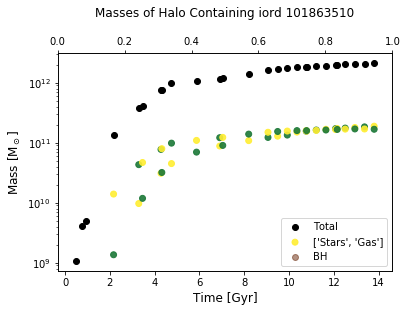

In [30]:
 for i in iords_list:
        iord_mass_plot_2(vars()['iord_%s'%(i)],i,time, halo_label=False, save=False, lc='best')

In [16]:
time

,time[Gyr],z
139,0.477443,9.954491e+00
225,0.767008,6.983808e+00
275,0.935360,5.992851e+00
640,2.164327,2.984615e+00
974,3.288917,1.999371e+00
1024,3.457268,1.898475e+00
1269,4.282192,1.499938e+00
1280,4.319229,1.484975e+00
1408,4.750210,1.324819e+00
1740,5.868065,9.997720e-01
